In [1]:
import scalebar
import cv2
import numpy as np
import logging
import skimage

from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt

from scalebar import utils
from pathlib import Path
from tqdm.auto import tqdm
from dataclasses import dataclass


In [2]:
BLACK = 0
GRAY = 127
WHITE = 255

@dataclass
class Args:
    image_path: str

    roi_fraction: float = 0.15

In [3]:
def hide_non_roi(im, fraction: float, value, min_size: int = 200):
    res = im.copy()
    H, W, *_ = im.shape
    if min(H, W) < min_size*2:
        return res

    y0, x0 = max(int(H*fraction), min_size), max(int(W*fraction), min_size)
    res[y0:H-y0, x0:W-x0] = value
    return res

In [4]:
def imshow(ims):

    if len(ims) <= 3:
        nrows, ncols = 1, len(ims)
    else:
        nrows = int(np.ceil(np.sqrt(len(ims))))
        ncols = int(np.ceil( len(ims) / nrows))

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows,figsize=(16,9), squeeze=False)
    for i, (title, im, cmap) in enumerate(ims):
        ax = axs[np.unravel_index(i, axs.shape)]

        if isinstance(im, (list, tuple)):
            alpha = 1 / len(im)
            for _im, _cm in zip(im, cmap):
                ax.imshow(_im, cmap=_cm, alpha=alpha)
        else:
            ax.imshow(im, cmap=cmap)
        ax.set_title(title)

    return fig, axs

In [5]:
def find_scalebar(match, enlarge):

    # Finding contours for the thresholded image
    contours, hierarchy = cv2.findContours(match, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cont_im = np.full_like(match, BLACK)
    cont_im = cv2.drawContours(cont_im, contours, -1, WHITE, 2)

    coords = np.zeros((len(contours), 2), dtype=np.int32)
    for i, cnt in enumerate(contours):
        x,y,w,h = cv2.boundingRect(cnt)
        coords[i, 0] = x + w//2
        coords[i, 1] = y + h//2

    mean, std = coords.mean(axis=0), coords.std(axis=0)
    low, high = mean - 2*std, mean + 2*std
    xs, ys = coords.T

    mask = np.logical_and(
        (low[0] <= xs) & (xs <= high[0]),
        (low[1] <= ys) & (ys <= high[1])
    )

    coords = coords[mask]
    H, W = match.shape[:2]
    x0, y0 = np.maximum(coords.min(axis=0) - enlarge, 0)
    x1, y1 = np.minimum(coords.max(axis=0) + 2*enlarge, (W, H))
    return x0, y0, x1-x0, y1-y0
    # peaks = skimage.feature.peak_local_max(match, min_distance=int(1.5*temp_size))
    # ys, xs = peaks.T
    # axs[np.unravel_index(0, axs.shape)].scatter(xs, ys, marker="x")


In [6]:
def match_scalebar(bin_im, template_size: int):

    template = np.full((2*template_size, 2*template_size), BLACK, dtype=bin_im.dtype)
    template[:template_size, template_size:] = WHITE
    template[template_size:, :template_size] = WHITE

    padding = (template_size, template_size-1)
    match = np.abs(cv2.matchTemplate(bin_im, template, method=cv2.TM_CCOEFF_NORMED))
    match = np.pad(match, (padding, padding))
    assert bin_im.shape == match.shape

    match -= match.min()
    match /=  (match.max() or 1)
    match = (match * 255).astype(np.uint8)

    _, match = cv2.threshold(match, GRAY, WHITE, cv2.THRESH_BINARY)

    return match, template

In [7]:
def threshold(im, thresh_type: int):
    return cv2.threshold(im, GRAY//2, WHITE, thresh_type)[-1]


In [236]:
def optimal_distance(distances: np.ndarray) -> float:
    """
        Estimates the best distance by solving an
        optimization problem
    """

    smallest_err = np.inf
    best_distance = None
    distances = distances[distances!=0]
    # max_d = np.percentile(distances, 20)
    # min_d = distances.min()#, np.percentile(distances, 1))
    # print(distances.min(), distances.max())
    # print(min_d, max_d)

    # errors = [[], []]
    # n_prots = []
    dist_candidates = sorted(np.unique(np.maximum(distances, 10)))
    dist_candidates = dist_candidates[:len(dist_candidates)//5]
    #np.arange(min_d, max_d, 1)

    for i, d in enumerate(dist_candidates):
        norm_dist = distances / d
        grid = np.arange(0, np.max(distances) + d, d) / d

        if len(grid) <= 2:
            print(f"FOO: {d}")
            continue

        # compute quantization error
        bins = (grid[:-1] + grid[1:]) / 2.0

        prototypes = grid[1:-1]
        # n_prots.append(len(prototypes))
        bin_idxs = np.digitize(norm_dist, bins)

        # print(d, bin_idxs)
        bin_idxs -= 1
        bin_idxs[bin_idxs == -1] = 0
        bin_idxs[bin_idxs == len(prototypes)] = len(prototypes) - 1

        # quantization error with BIC model selection
        # adhoc version
        n = len(norm_dist)
        err0 = np.linalg.norm((norm_dist - prototypes[bin_idxs]))
        err = err0 #+ len(prototypes) * np.log(n)
        # theoretically derived criterion
        # err = n * np.log(2 * np.pi) + \
        #     np.linalg.norm(distances - prototypes[bin_idxs])**2 + \
        #     len(prototypes) * np.log(n)

        # errors[0].append(err0)
        # errors[1].append(err)
        if err < smallest_err:
            # print(f"[{i: 4d}] new distance selected: {d} [{smallest_err} -> {err}]")
            smallest_err, best_distance = err, d

        # elif 56<= d <=120:
        #     print(f"Error for {d} was higher: [{smallest_err} < {err}]")

    # fig, ax = plt.subplots(figsize=(12,8))

    # ax.plot(dist_candidates, errors[0])
    # ax.plot(dist_candidates, errors[1])
    # ax = ax.twinx()
    # ax.plot(dist_candidates, np.log(n_prots), linestyle="dashed")

    return best_distance


In [237]:
def estimate(crop, match, *,
             min_distance:int,
             max_corners: int = 50,
             ):

    bin_im = threshold(crop, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    corners = cv2.goodFeaturesToTrack(bin_im,
                                      0 if np.isinf(max_corners) else max_corners,
                                      qualityLevel=0.1,
                                      minDistance=min_distance,
                                      mask=match,
                                    )
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    shape = (2*min_distance+1, 2*min_distance+1)
    corners = cv2.cornerSubPix(crop, corners, shape, (-1,-1), criteria)
    # switch x and y coordinates for convenience (needed only for OpenCV)
    corners = corners[:, 0, ::-1].astype(int)

    distances = pdist(corners, metric="cityblock")

    unit_distance = optimal_distance(distances)

    fig, axs = imshow([
        (f"Scalebar | {unit_distance} px/mm", crop, plt.cm.gray),
        ("Binarized", bin_im, plt.cm.gray),
        ("Match", match, plt.cm.viridis),
    ])

    ax = axs[np.unravel_index(1, axs.shape)]
    ys, xs = corners.transpose(1, 0)
    ax.scatter(xs, ys, marker=".", c="red")

    return unit_distance


In [244]:
def main(args: Args):
    impath = Path(args.image_path)
    im = utils.read_image(impath)
    H, W, *C, = im.shape
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    hue, sat, val = cv2.cvtColor(im, cv2.COLOR_RGB2HSV).transpose(2, 0, 1)

    eq_gray = cv2.equalizeHist(gray)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    eq_gray = clahe.apply(gray)
    # imshow([
    #     ("Original", im, None),
    #     ("B/W image", gray, plt.cm.gray),
    #     ("B/W image equalized", eq_gray, plt.cm.gray),
    #     ("Saturation", sat, plt.cm.gray),
    # ])

    size = max(int(min(H, W) * 2e-3), 1)
    kernel_size = size * 2 + 1
    kernel_shape = (kernel_size, kernel_size)
    temp_size = size * 5

    # fig, ax = plt.subplots(figsize=(16,9))
    # ax.hist(gray.ravel(), bins=128)
    bin_im = threshold(eq_gray, cv2.THRESH_BINARY)

    # bin_im = cv2.adaptiveThreshold(gray, WHITE,
    #                                cv2.ADAPTIVE_THRESH_MEAN_C,
    #                                cv2.THRESH_BINARY, min(H, W)//10 * 2 + 1, 0)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_shape, (size, size))
    bin_im = cv2.dilate(cv2.erode(bin_im, kernel=kernel, iterations=2), kernel=kernel, iterations=2)

    ROI = hide_non_roi(bin_im, args.roi_fraction, GRAY)
    bin_im_masked = hide_non_roi(bin_im, args.roi_fraction, WHITE)
    # imshow([
    #     ("Binarized", bin_im, plt.cm.gray),
    #     ("ROI to be masked", ROI, plt.cm.gray),
    #     ("Masked", bin_im_masked, plt.cm.gray),
    # ])


    match, template = match_scalebar(bin_im_masked, template_size=temp_size)
    x, y, w, h = find_scalebar(match, enlarge=temp_size)

    scalebar_crop = eq_gray[y:y+h, x:x+w]
    matched_crop = match[y:y+h, x:x+w]

    # fig, axs = imshow([
    #     ("Template Matches", (bin_im, match), (plt.cm.gray, plt.cm.viridis)),
    #     ("Scalebar", scalebar_crop, plt.cm.gray),
    # ])


    # ax = axs[np.unravel_index(0, axs.shape)]
    # ax.add_patch(plt.Rectangle((x, y), width=w, height=h, fill=False))

    # scale = estimate(cv2.resize(scalebar_crop, None, None, 2, 2),
    #                  cv2.resize(matched_crop, None, None, 2, 2),
    #                  min_distance=size*2)
    scale = estimate(scalebar_crop, matched_crop, min_distance=size)
    # scale = estimate(cv2.resize(scalebar_crop, None, None, 0.5, 0.5),
    #                  cv2.resize(matched_crop, None, None, 0.5, 0.5),
    #                  min_distance=size//2)
    # scale = estimate(cv2.resize(scalebar_crop, None, None, 0.25, 0.25),
    #                  cv2.resize(matched_crop, None, None, 0.25, 0.25),
    #                  min_distance=size//4)

    plt.show()
    plt.close()


  0%|          | 0/3 [00:00<?, ?it/s]

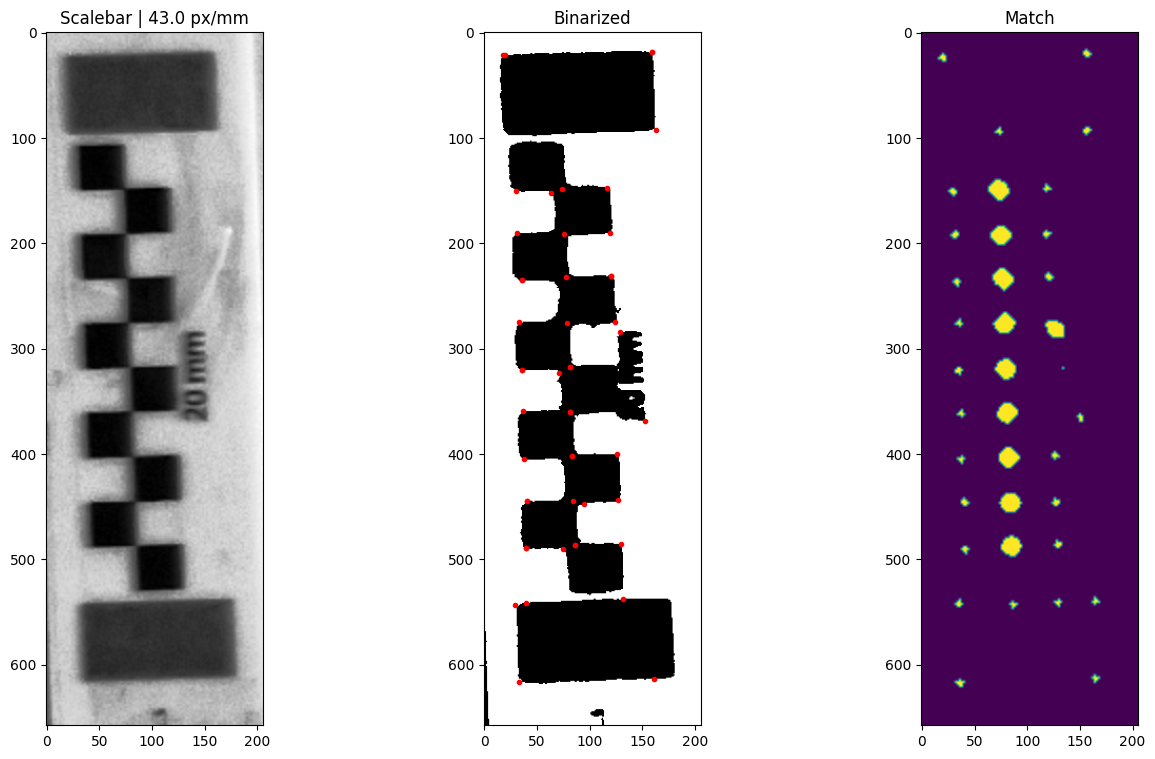

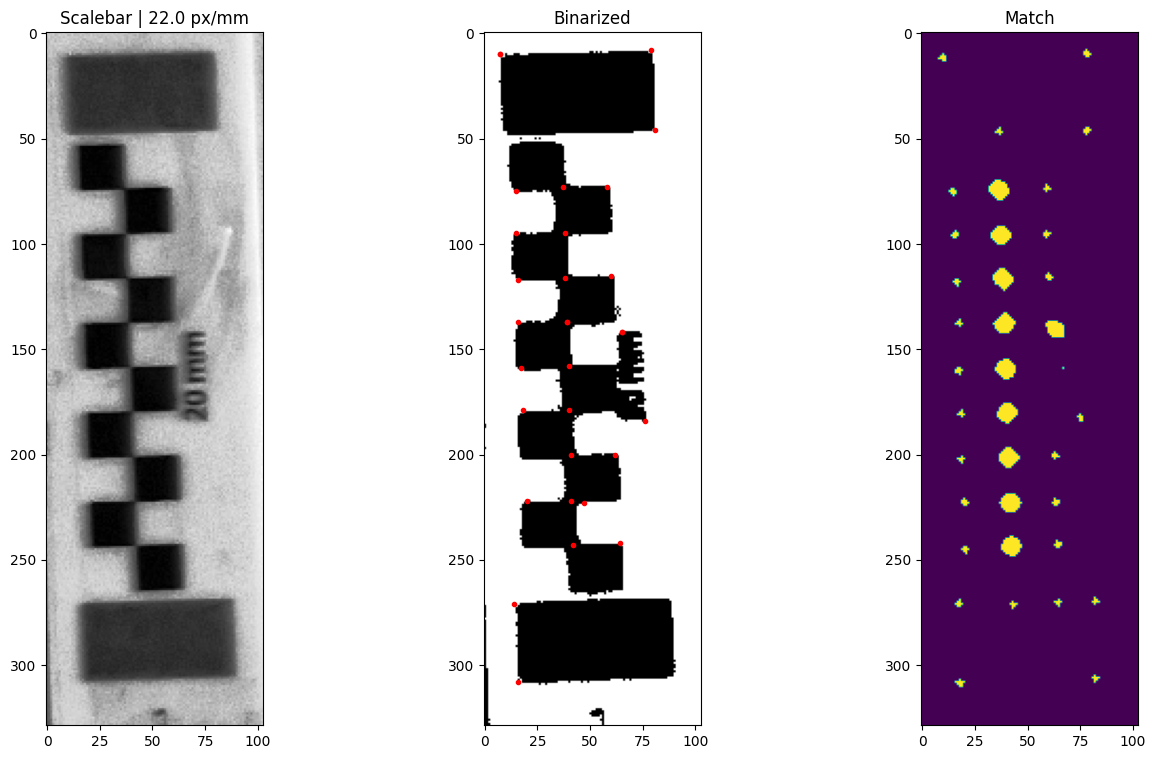

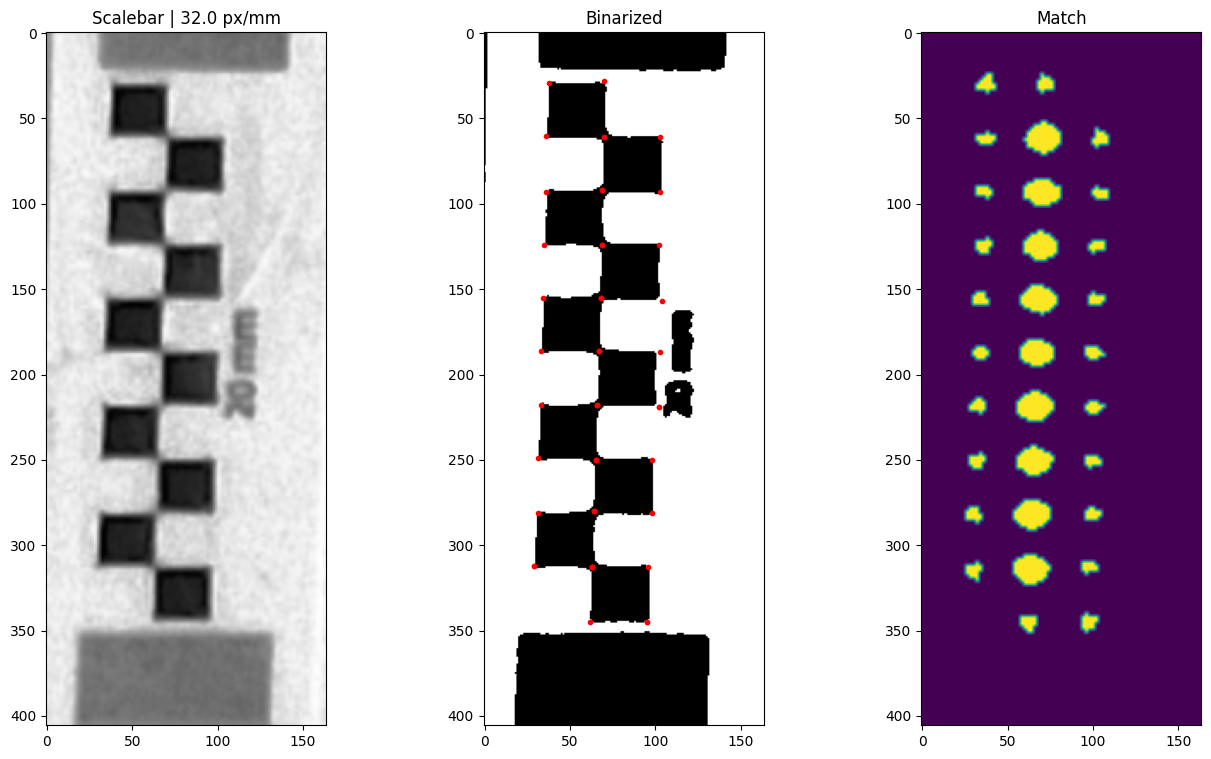

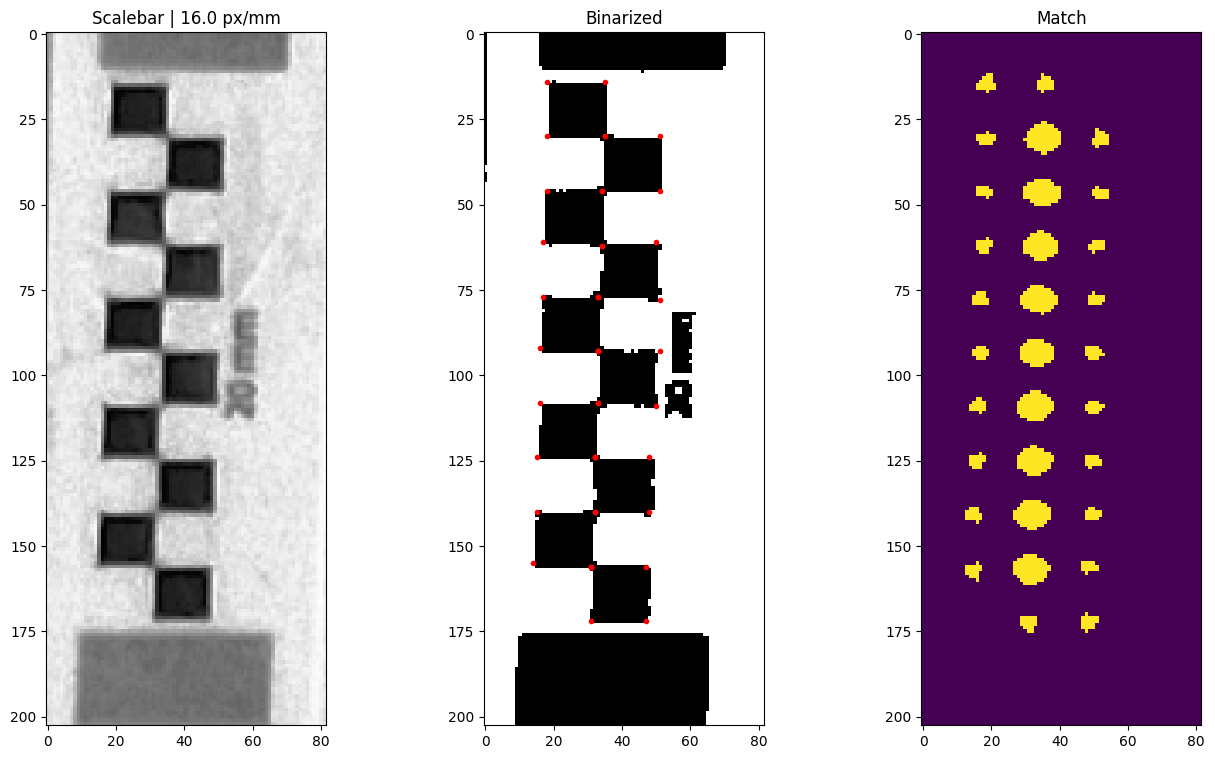

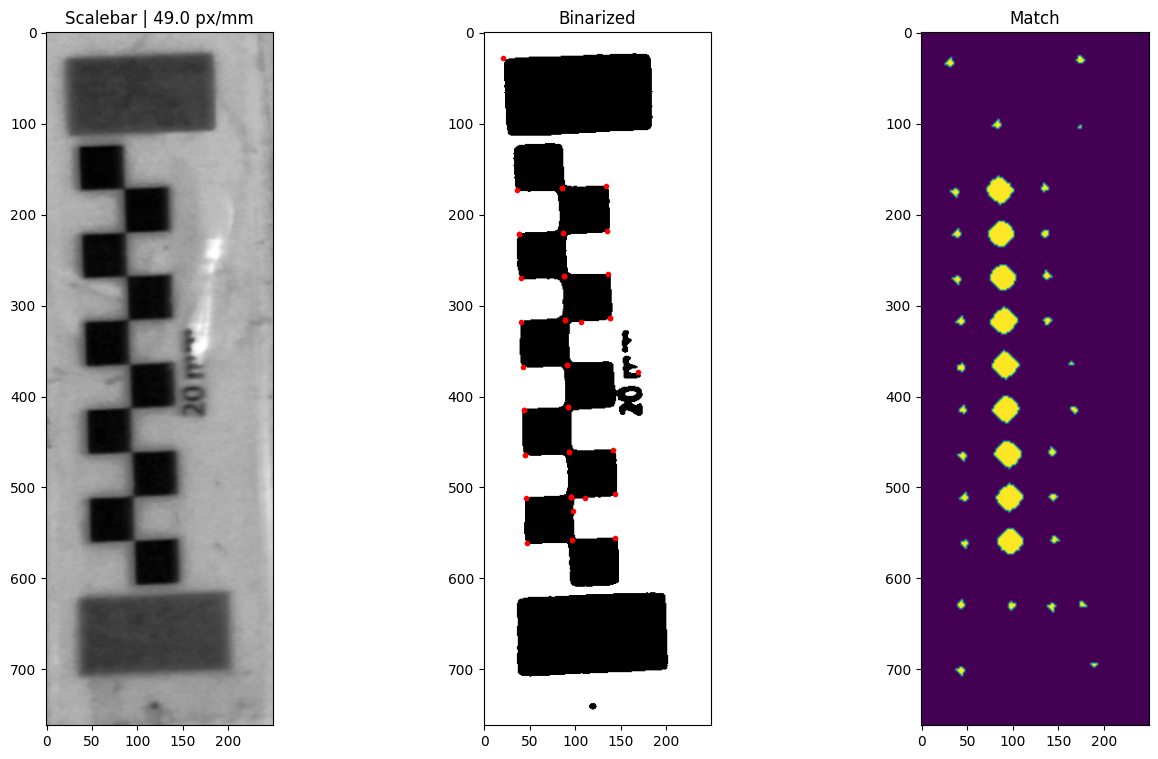

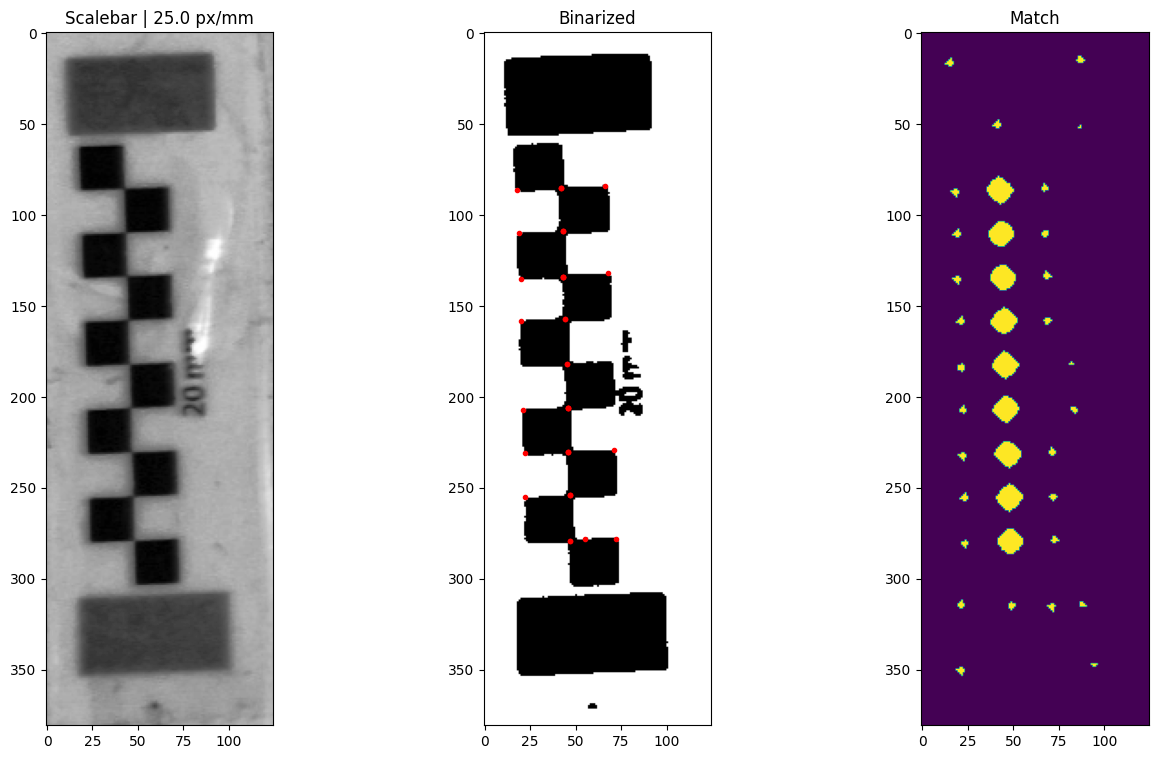

In [246]:
ims = [
    # "../examples/Pe-Geo-5149u.jpg",
    # "../examples/Pe-Geo-5149u-big.jpg",
    "../examples/20240530_175508.jpg",
    "../examples/20240530_174728.jpg",
    "../examples/20240531_141321.jpg",
]

# ims += list((Path.home() / "Data/datasets/mothseg/6_Masstabsbilder/").glob("*.jpg"))

for im in tqdm(ims):
    args = Args(im)
    main(args)